## <h1><center>[Created by Basil Khan]</center></h1>

## Import required modules/packages

In [1]:
import tensorflow as tf
import tensorboard
import imageio
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import datetime
import sklearn.metrics
import itertools

## Configure Tensorboard

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Clear prior logged data
!rd /s /q "logs/fit/basemetrics"

## Load X-Ray Dataset

In [4]:
# Get path for training and test dataset
training_data = Path('../data/train')
test_data = Path('../data/test')

In [5]:
# Get files in training data set
train_image_count = len(list(training_data.glob('*/*.jpeg')))
print('Training Data:',train_image_count,'images')
train_list_ds = tf.data.Dataset.list_files(str(training_data/'*/*'), shuffle=False)
train_list_ds = train_list_ds.shuffle(train_image_count, reshuffle_each_iteration=False)
test_image_count = len(list(test_data.glob('*/*.jpeg')))
print('Test Data:',test_image_count,'images')
test_list_ds = tf.data.Dataset.list_files(str(test_data/'*/*'), shuffle=False)
test_list_ds = test_list_ds.shuffle(test_image_count, reshuffle_each_iteration=False)

Training Data: 5216 images
Test Data: 624 images


## Convert filepaths to images and labels

In [6]:
# Convert filepath to image+label pair
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [7]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [8]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [9]:
def get_path(file_path):
  filepath = file_path
  return filepath

In [10]:
batch_size = 32
img_height = 227
img_width = 227
AUTOTUNE = tf.data.experimental.AUTOTUNE
class_names = ["NORMAL", "PNEUMONIA"]
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE, deterministic=True)
train_ds_filepath = train_list_ds.map(get_path, num_parallel_calls=AUTOTUNE, deterministic=True)
val_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_filepath = test_list_ds.map(get_path, num_parallel_calls=AUTOTUNE, deterministic=True)

## Extract X (images) and Y (labels) from tensorflow dataset

In [11]:
# Extract X and Y From Training Dataset
train_x = []
train_y = []
for sample in train_ds:
    train_x.append(sample[0].numpy())
    train_y.append(tf.keras.utils.to_categorical(sample[1].numpy(), num_classes=2))
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
# View Image>> plt.imshow(train_x[train_rand_sample_index[0],:,:,0], interpolation = 'nearest')
# View Label>> class_names[np.argmax(train_y[train_rand_sample_index[0]])]

In [12]:
# Extract X and Y From Test Dataset
val_x = []
val_y = []
for sample in val_ds:
    val_x.append(sample[0].numpy())
    val_y.append(tf.keras.utils.to_categorical(sample[1].numpy(), num_classes=2))
val_x = np.asarray(val_x)
val_y = np.asarray(val_y)
# View Image>> plt.imshow(val_x[val_rand_sample_index[0],:,:,0], interpolation = 'nearest')
# View Label>> class_names[np.argmax(val_y[val_rand_sample_index[0]])]

## Pre-process dataset

In [13]:
# Tweak Dataset
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds
train_ds = configure_for_performance(train_ds)
train_ds_filepath = configure_for_performance(train_ds_filepath)
val_ds = configure_for_performance(val_ds)
val_ds_filepath = configure_for_performance(val_ds_filepath)

## Visualize random observations from training set

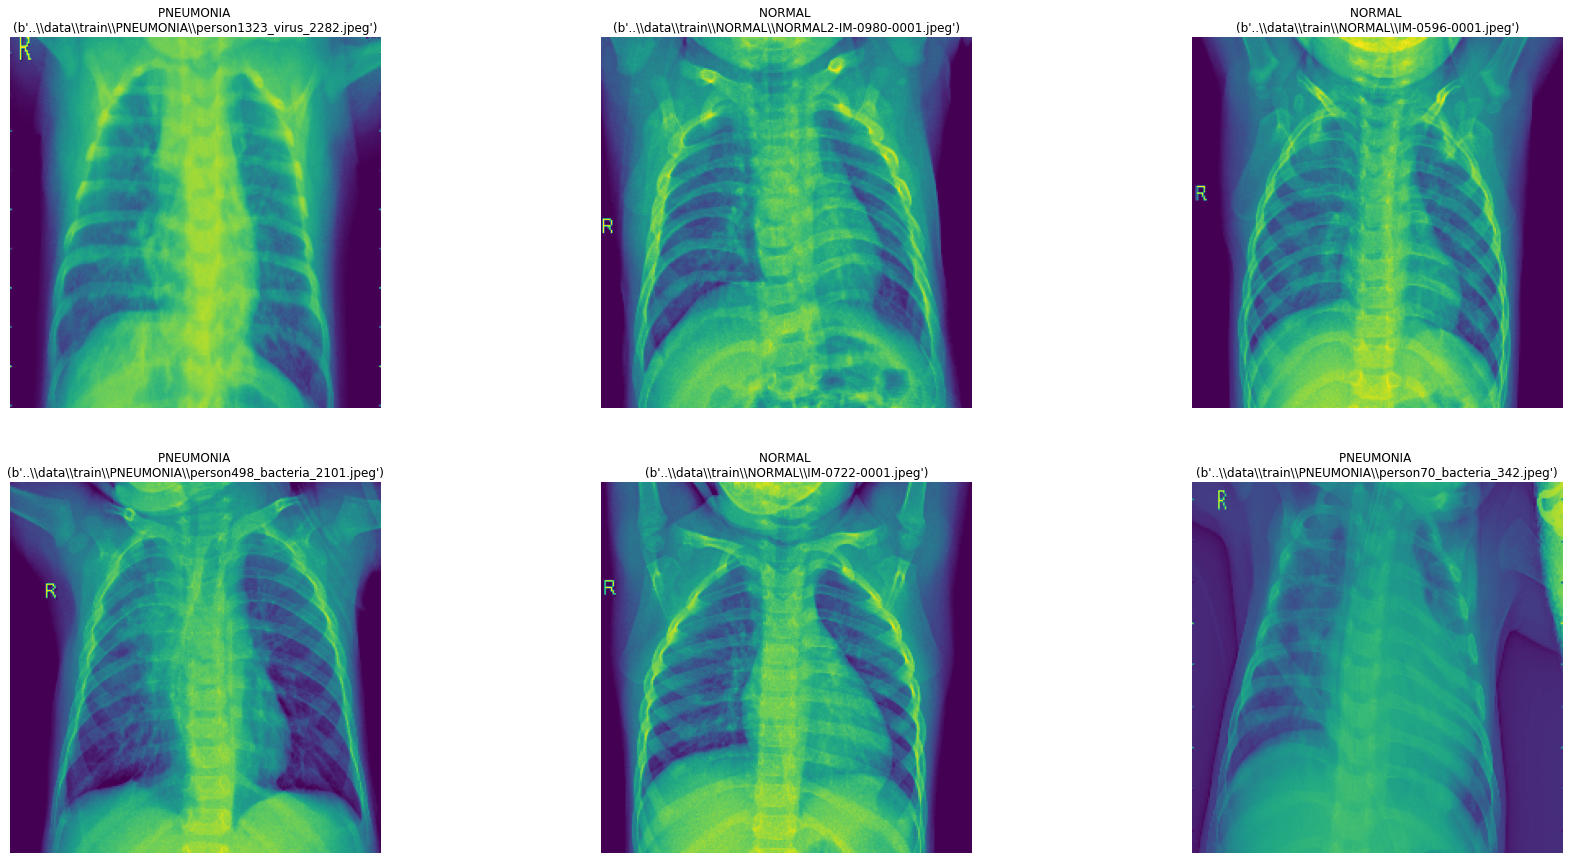

In [14]:
# visualize training data
image_batch, label_batch = next(iter(train_ds))
path_batch = next(iter(train_ds_filepath))
plt.figure(figsize=(30, 15))
train_rand_sample_index = []
for i, j in zip(list(range(6)), random.sample(range(batch_size), 6)):
  train_rand_sample_index.append(j)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(image_batch[j].numpy().astype("uint8"))
  label = label_batch[j]
  filename = path_batch[j].numpy()
  ax.set_title("{} \n({})".format(class_names[label], filename))
  plt.axis("off")

## Define and Build CNN architecture

In [15]:
# create model
num_classes = 2
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 227, 227, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 227, 227, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

## Setup Tensorboard logging

In [18]:
# Setup tensorboard for training data
logdir_fit = "logs/fit/base" + datetime.datetime.now().strftime("metrics")
tensorboard_callback_fit = tf.keras.callbacks.TensorBoard(log_dir=logdir_fit, histogram_freq=1)

## Setup confusion matrix calculation

In [19]:
def plot_confusion_matrix(cm, class_names):
  figure = plt.figure(figsize=(7, 7))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')  

In [20]:
def log_confusion_matrix():
  y_hat = model.predict(val_ds)
  predict_label = np.array([[None] * 624] * 1).reshape(624,)
  grnd_truth_label = np.array([[None] * 624] * 1).reshape(624,)
  for i in list(range(624)):
    predict_label[i] = class_names[np.argmax(y_hat[i,:], axis=0)]
    grnd_truth_label[i] = class_names[np.argmax(val_y[i])]

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(grnd_truth_label, predict_label)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  return figure

## Train CNN

In [21]:
# Train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback_fit]
)

Epoch 1/20
  1/163 [..............................] - ETA: 0s - loss: 0.7370 - accuracy: 0.1875WARNING:tensorflow:From C:\Users\bkhan17\Anaconda3\envs\py376\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
163/163 [==============================] - 7s 43ms/step - loss: 0.2505 - accuracy: 0.8995 - val_loss: 0.8525 - val_accuracy: 0.7548
Epoch 2/20
163/163 [==============================] - 5s 28ms/step - loss: 0.0998 - accuracy: 0.9632 - val_loss: 0.7163 - val_accuracy: 0.7853
Epoch 3/20
163/163 [==============================] - 5s 28ms/step - loss: 0.0750 - accuracy: 0.9732 - val_loss: 1.0936 - val_accuracy: 0.7340
Epoch 4/20
163/163 [==============================] - 5s 29ms/step - loss: 0.0659 - accuracy: 0.9785 - val_loss: 1.0375 - val_accuracy: 0.7548
Epoch 5/20
163/163 [=============================

## View confusion matrix

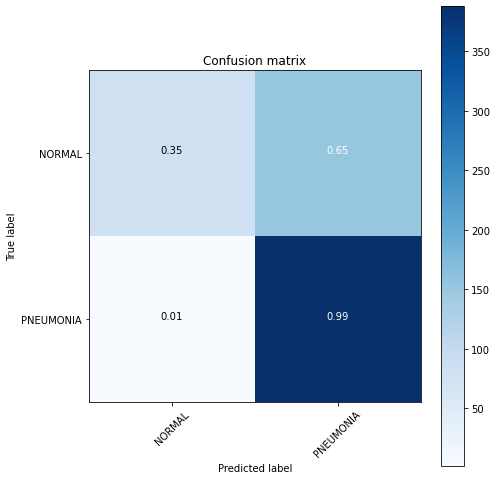

In [22]:
log_confusion_matrix()

## Viewing Tensorboard logs

In [23]:
# View tensorboard logs
# In conda prompt type > tensorboard --logdir=logs\fit\basemetrics
# Navigate to localhost address provided

## Visualize random samples from test set with predicted and groud truth labels

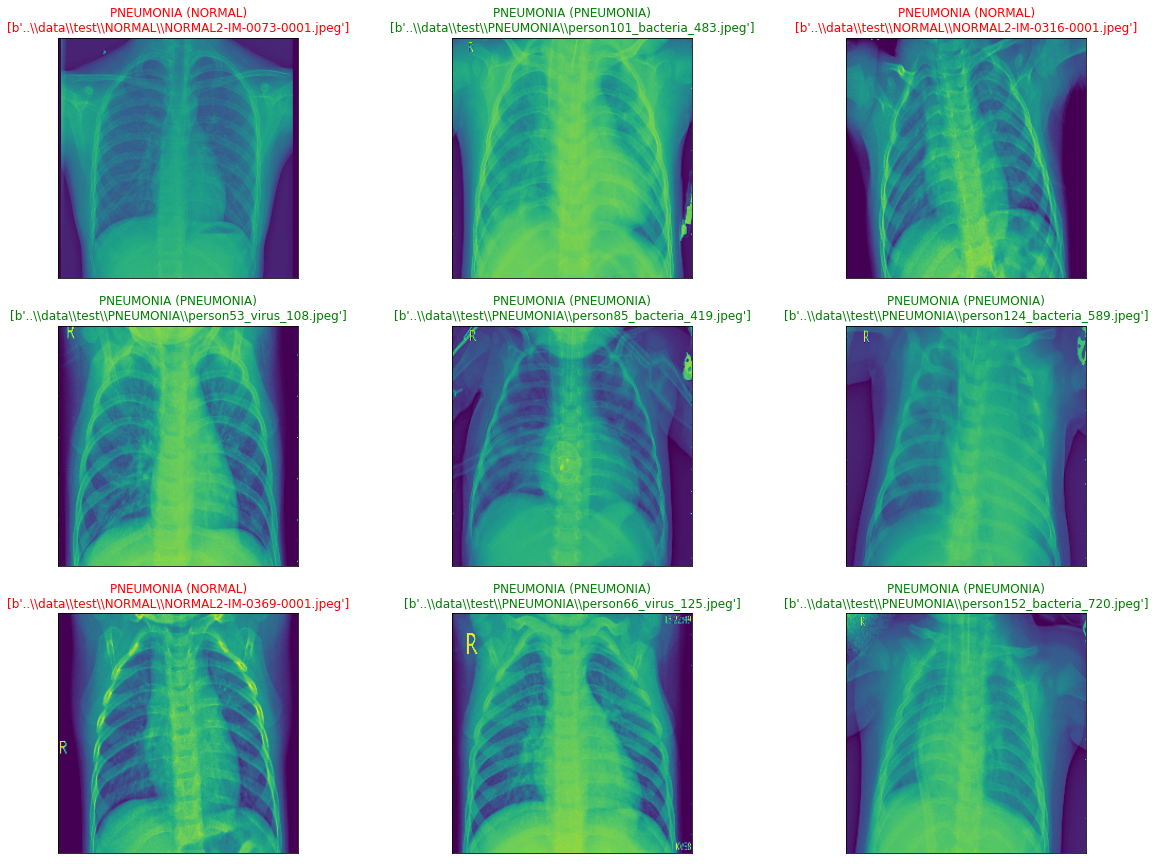

In [24]:
# Visualize predictions and true images
# Plot a random sample of 9 test images, their predicted labels and ground truth
test_image_batch, test_label_batch = next(iter(val_ds))
test_path_batch = next(iter(val_ds_filepath))
y_hat = model.predict(val_ds)
predict_label = np.array([[None] * 624] * 1).reshape(624,)
grnd_truth_label = np.array([[None] * 624] * 1).reshape(624,)
for i in list(range(624)):
    predict_label[i] = class_names[np.argmax(y_hat[i,:], axis=0)]
    grnd_truth_label[i] = class_names[np.argmax(val_y[i])]
figure = plt.figure(figsize=(20, 15))
val_rand_sample_index = []
for i, j in zip(list(range(9)), random.sample(range(batch_size), 9)):
    val_rand_sample_index.append(j)
    ax = figure.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    # Display each image
    val_image = test_image_batch[j]
    plt.imshow(test_image_batch[j].numpy().astype("uint8"))
    predicted_label = predict_label[j]
    true_label = class_names[test_label_batch[j]]
    filename = test_path_batch[j].numpy()
    # Set the title for each image
    ax.set_title("{} ({})\n[{}]".format(predicted_label,
                                  true_label,
                                  filename),
                                  color=("green" if predicted_label == true_label else "red"))

## Visualize CNN performance metrics

In [25]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

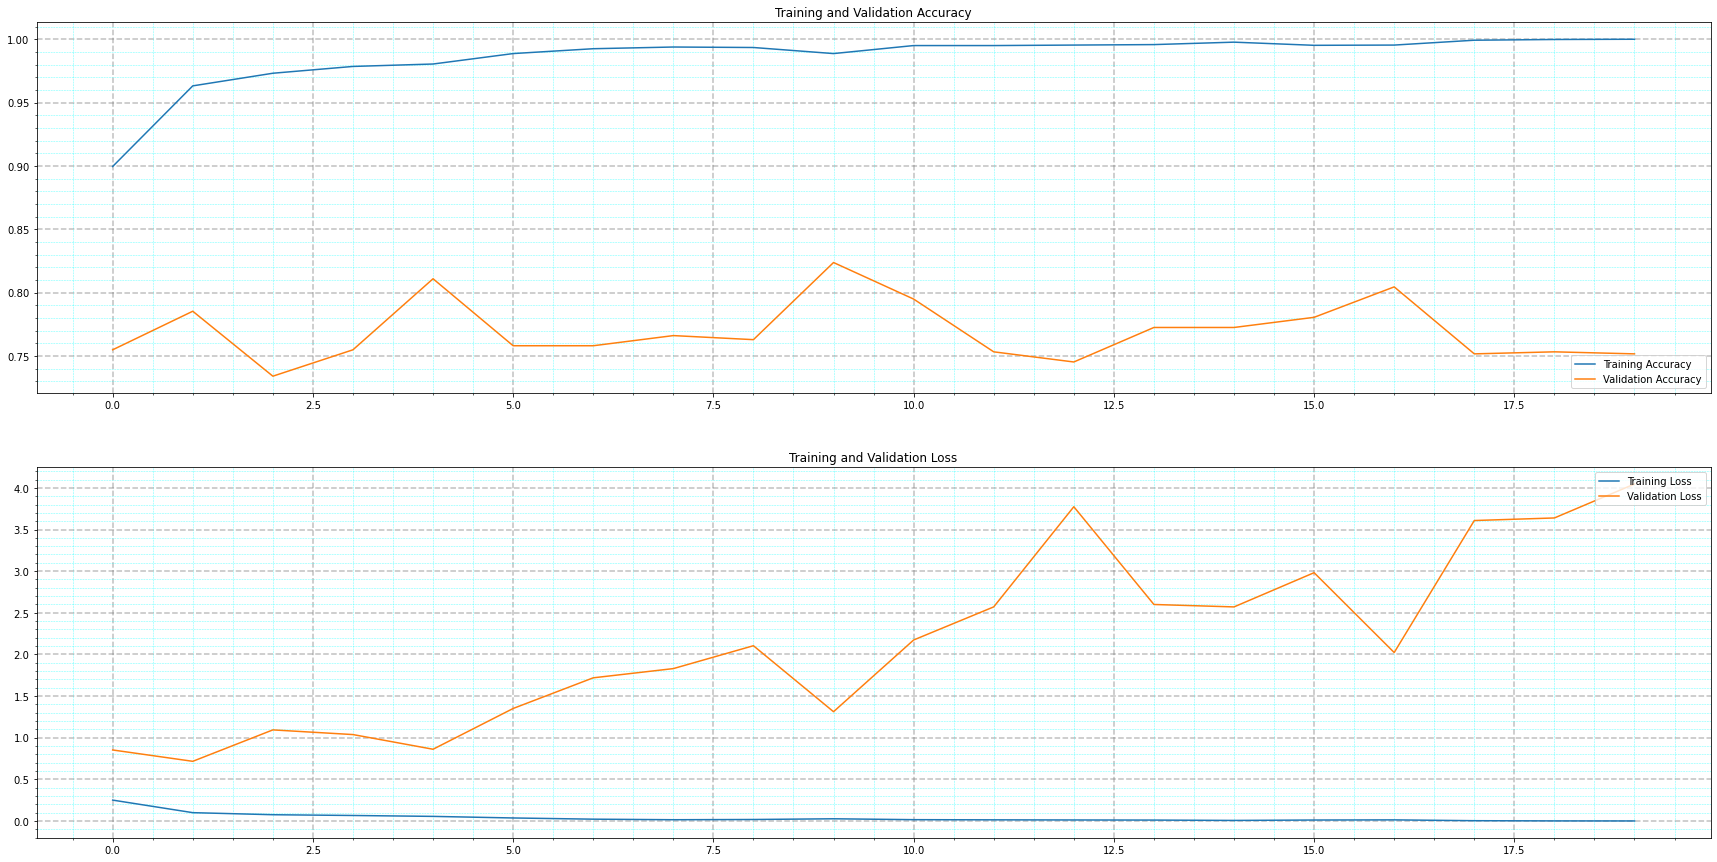

In [26]:
epochs_range = range(epochs)
plt.figure(figsize=(30, 15))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(color='grey', which='major',alpha=0.5,linestyle='--',linewidth=1.5)
plt.minorticks_on()
plt.grid(color='aqua', which='minor',alpha=0.6,linestyle='--',linewidth=0.5)

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(color='grey', which='major',alpha=0.5,linestyle='--',linewidth=1.5)
plt.minorticks_on()
plt.grid(color='aqua', which='minor',alpha=0.6,linestyle='--',linewidth=0.5)